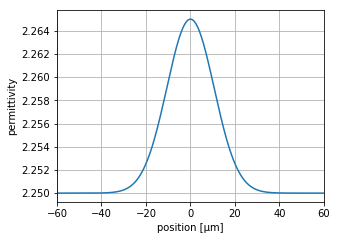

In [69]:
#Computation Photonics Seminar 3
#Darko Gilbert 
#Index 183145

#Task I: Calculate TE eigenmodes of a film waveguide
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

def guided_modes_1DTE (prm , k0, h):
    """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    Parameters
    ----------
    prm
    : 1d array
    Dielectric permittivity in the x
    direction
    k0 : float
    Free space wavenumber
    h : float
    Spatial discretization
    Returns
    -------
    eff_eps
    : 1d array
    Effective permittivity vector of calculated modes
    guided : 2d
    array
    Field distributions of the guided eigenmodes
    """
    #Main diagonal in the matrix
    prime_diag = -2*np.ones(len(prm),)/(h**2*k0**2) + prm
    
    #Side diagonal, to be negated to represent diagonal below the main.
    next_diag = np.ones((len(prm)-1,))/(h**2*k0**2)
    
    #L in TE mode, to be solved eigen value problem.
    L_TE = np.diag(-next_diag, k=-1) + np.diag(prime_diag, k=0) + np.diag(next_diag, k=1)
    
    #Eigen value problem
    eff_eps, guided = np.linalg.eig(L_TE)
    ind = eff_eps > max(prm[0], prm[-1])
    eff_eps = eff_eps[ind]
    guided  = guided[:,ind]  
    
    # sort modes from highest
    # (the fundamental mode h
    I = np.argsort(-eff_eps);
    eff_eps = eff_eps[I]    
    guided = guided[:,I]    
    
    return eff_eps, guided  
#All lengths are in micrometers(10^-6)
grid_size = 120
number_of_points = 601
h = grid_size/(number_of_points-1)
lamda = 0.78
k0 = 2*np.pi/lamda
x = np.linspace(-grid_size*0.5, grid_size*0.5, number_of_points)

w = 15
delta_e = 0.015
e_substrate = 2.25
prm = e_substrate + delta_e * np.exp(-(x/w)**2)

#Test and Ploting 
eff_eps, guided = guided_modes_1DTE(prm, k0, h);

plt.figure()
plt.plot(x, prm, '-')
plt.xlabel('position [µm]');
plt.ylabel('permittivity');
plt.xlim(x[[0, -1]])
plt.show()



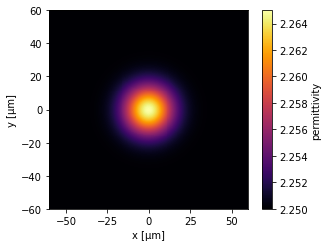

In [87]:
#Task II: Quasi-TE modes of a strip waveguide
            #Tried to follow from previous year's. 
import numpy as np
from matplotlib import pyplot as plt
import scipy.sparse as sps
from scipy.sparse.linalg import eigs

def guided_modes_2D(prm , k0, h, numb):
    """Computes the effective permittivity of a quasi
    TE polarized guided
    eigenmode. All dimensions are in µm.
    Parameters
    ----------
    prm
    : 2d array
    Dielectric permittivity in the
    xy plane
    k0 : float
    Free space wavenumber
    h : float
    Spatial discretization
    numb : int
    Number of eigenmodes to be calculated
    Returns
    -------
    eff_eps
    : 1d array
    Effective permittivity vector of calculated eigenmodes
    guided : 3d
    array
    Field distributions of the guided eigenmodes
    """
    NX, NY = prm.shape
    prm = prm*k0**2
    N = NX*NY
    ihx2 = 1/h**2
    ihy2 = 1/h**2

    md = -2.0*(ihx2 + ihy2)*np.ones((N,)) + prm.ravel(order='F')
    xd = ihx2*np.ones((N,))
    yd = ihy2*np.ones((N,))
    H  = sps.spdiags([yd,xd,md,xd,yd], [-NX,-1,0,1,NX], N, N, format='csc')

    #remove the '1' when moving to a new line
    # -> look into script pg. 31, lower blue line in first figure
    for i in range(1, NY):
        n = i*NX
        H[n-1, n] = 0
        H[n, n-1] = 0

    # solve eigenvalue problem
    eigvals, eigvecs = eigs(H, k=numb, which='LR', maxiter=3000)
    eff_eps = eigvals/(k0**2);

    # pick only guided modes
    eps_clad = max([prm[:,0].max(), prm[:,-1].max(),
                    prm[0,:].max(), prm[-1,:].max()])
    ind = eff_eps > eps_clad/k0**2
    eff_eps = eff_eps[ind]
    eigvecs = eigvecs[:,ind]

    # sort modes from highest to lowest effective permittivity
    # (the fundamental mode has the highest effective permittivity)
    I = np.argsort(-eff_eps);
    eff_eps = eff_eps[I]
    eigvecs = eigvecs[:,I]

    # reshape eigenvectors to a 2D matrix and store them in a 3D array
    guided = np.zeros((len(eff_eps),NX,NY), dtype=eigvecs.dtype)
    for i in range(len(eff_eps)):
       guided[i,:,:] = np.reshape(eigvecs[:,i], (NX,NY), order='F')

    return eff_eps, guided
# %%
grid_size     = 120
number_points = 601
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 1.5**2
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2);
yy            = np.linspace(-grid_size/2,grid_size/2,number_points);
prm           = e_substrate + delta_e * np.exp(-(xx/w)**2);

[x,y] = np.meshgrid(xx,yy, indexing='ij');

# make permittivity slightly asymmetric to enforce consistent orientation
# of eigenmodes
prm = e_substrate + delta_e*np.exp(-(x**2 + (1-1e-6)*y**2)/w**2)

plt.figure()
plt.pcolormesh(x, y, prm, cmap='inferno', zorder=-5)
plt.xlabel('x [µm]');
plt.ylabel('y [µm]');
plt.tight_layout()
plt.gca().set_aspect('equal')
plt.gca().set_rasterization_zorder(0)
cb = plt.colorbar(fraction=0.2)
cb.set_label('permittivity')
plt.show()